## Advanced Lane Lines

The goal of this project is :
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position in a video.

and the steps of this project are the following:
* 1)Cabera Calibration: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. Apply a distortion correction to raw images.
* 2)Threshold image: Use color transforms, gradients, etc., to create a thresholded binary image.
* 3)Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [57]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

%matplotlib inline

## Camera Calibration

In [2]:
# read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg' )

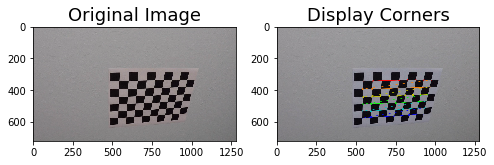

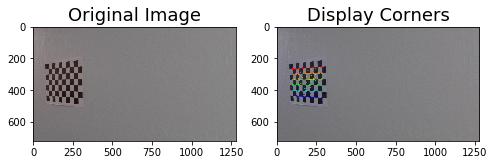

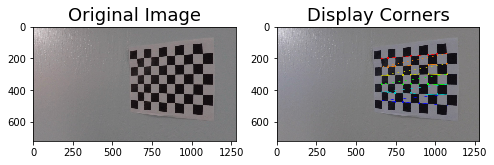

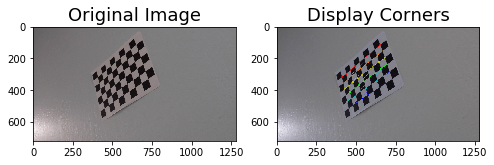

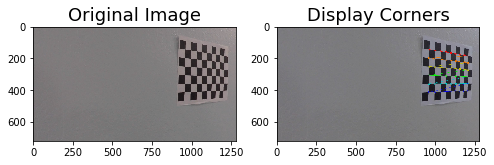

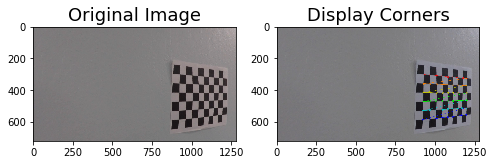

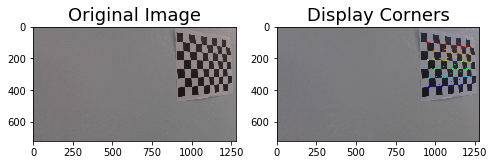

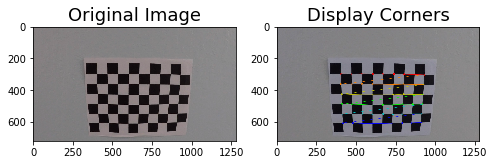

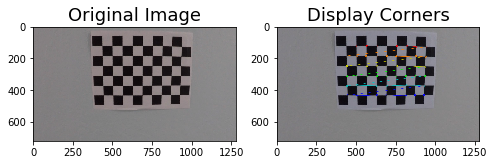

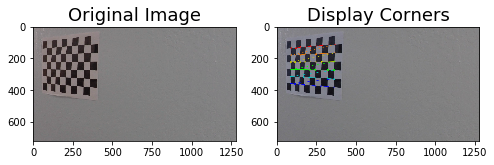

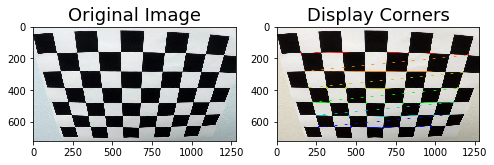

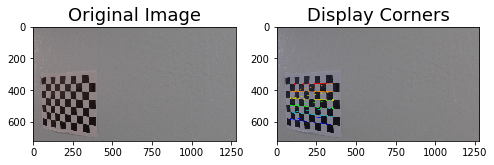

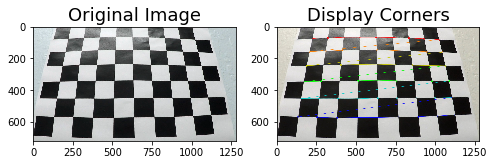

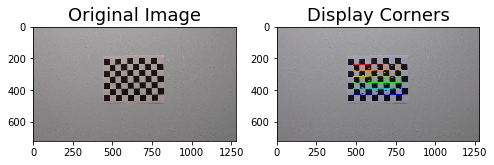

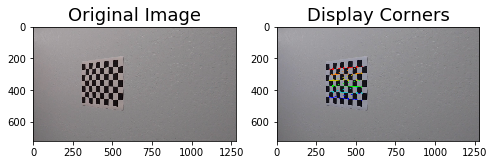

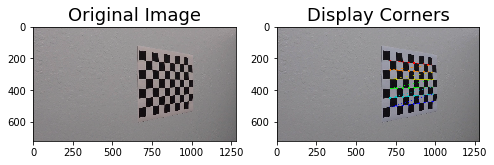

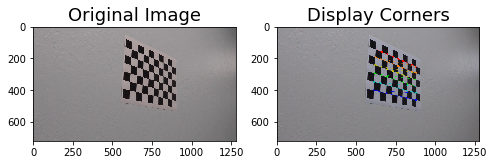

In [3]:
# prepare object points
nx=9
ny=6
#arrays to store object points and image points from all images
objpoints = [] #3D points in real world space
imgpoints = [] #2D points in image plane

#prepare object points like (0,0,0)  (1,0,0), (2,0,0),... (7,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2]= np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x,y coordinates

for fname in images:
    #read image
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=18)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('Display Corners', fontsize=18)

In [4]:
def cal_undistort(img, show=True):
    #img = mpimg.imread(img)
    # img.shape[0:2] for color image
    # gray.shape[::-1] for grayscale image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        #ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.imshow(img)
        ax1.set_title('Original', fontsize=50)
        #ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.imshow(undist)
        ax2.set_title('Undistorted', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return undist



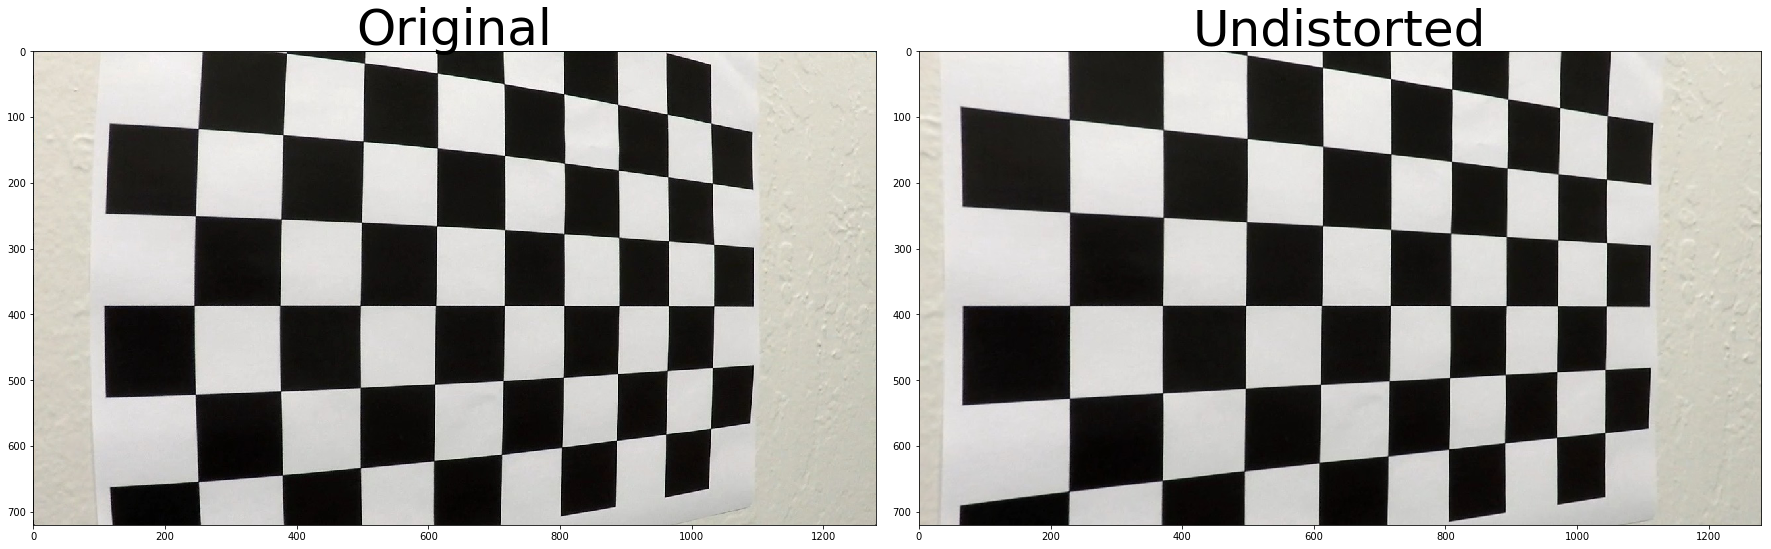

In [108]:
image = 'camera_cal/calibration5.jpg'
img =  mpimg.imread(image)
undist_img = cal_undistort(img)

## Threshold image

In [68]:
# help functions

def abs_sobel_thresh(img, orient='x',sobel_kernel=11, thresh=(25, 255)):
    #expects a gay image
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #l_channel = hsv[:,:,1]
    #s_channel = hsv[:,:,2]

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        #Calculate the derivative in the x direction (the 1, 0 at the end denotes x direction):
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    else:
        #Calculate the derivative in the y direction (the 0, 1 at the end denotes y direction):
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary
 

def mag_thresh(img, sobel_kernel=11, mag_thresh=(25, 255)):
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    # 5) Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return sbinary

def dir_threshold(img, sobel_kernel=11, thresh=(0, 1.5)):
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(grad_direction)
    sbinary[(grad_direction >= thresh[0]) & (grad_direction <= thresh[1])] = 1
    
    
    # 6) Return this mask as your binary_output image
    return sbinary

In [66]:
def cal_threshold_base(img,s_thresh=(90, 255), sx_thresh=(20, 180), show=True):
    #img=cal_undistort(img,show=False)
    
    #
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    #
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    h_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
      
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1 
    
    # Stack each channel
    lumAbsBin =abs_sobel_thresh(l_channel,'x',3,(20,100)) 
    xAbsBin = abs_sobel_thresh(s_channel,'x',3,(20,100))
    yAbsBin = abs_sobel_thresh(s_channel,'y',3,(20,100))
    magBin = mag_thresh(v_channel,9,(30,100))
    dirBin = dir_threshold(v_channel,15,(0.7,1.2))
    
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined_binary_temp = np.zeros_like(sxbinary)
    combined_binary_temp[(v_channel >= 227 | ((s_channel >= 150) | (xAbsBin == 1)) | ((magBin == 1) & (dirBin == 0)))] = 1
    
    #color filters
    HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # For yellow
    yellow = cv2.inRange(HSV, (20, 100, 100), (50, 255, 255))

    # For white
    sensitivity_1 = 68 
    white = cv2.inRange(HSV, (0,0,255-sensitivity_1), (255,20,255))

    sensitivity_2 = 60
    HSL = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    white_2 = cv2.inRange(HSL, (0,255-sensitivity_2,0), (255,255,sensitivity_2))
    
    lower_white = np.array([200,200,120])
    upper_white = np.array([255,255,255])
    white_3 = cv2.inRange(img, lower_white, upper_white)
    #white_3 = cv2.inRange(img, (150,150,150), (250,250,250))

    combined_binary = combined_binary_temp | yellow | white | white_2 | white_3
    #combined_binary_=np.dstack(( np.zeros_like(combined_binary_temp), combined_binary_temp, combined_binary_temp))
    #combined_binary_ [(combined_binary_temp==1) | (yellow==1) | (white==1) | (white_2==1) | (white_3==1)]=1
    
    
    #color_binary = np.zeros_like(scaled_sobel)
    #color_binary[(sxbinary == 1) | (s_binary == 1) ] = 1
    #color_binary = np.dstack(( color_binary,color_binary,color_binary)).astype(np.float32)

    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Undistorted', fontsize=50)
        ax2.imshow(combined_binary,cmap='gray')
        ax2.set_title('Thresholded ', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    return combined_binary #, white, white_2, white_3

## Perspective Transform ( birds-eye view )

In [ ]:
#%matplotlib qt
# Read in an image
#img = mpimg.imread('test_images/straight_lines1.jpg')
#plt.imshow(img)
#%matplotlib inline

In [7]:
def cal_perspective(undist, show=True): 
    #undist = cal_threshold_base(img,s_thresh=(170, 255), sx_thresh=(20, 80),show = False)
    
    img_size = (undist.shape[1], undist.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform( dst,src)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    if show:
        color=(0,123,255)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        #cv2.line(undist, (490, 482), (810, 482),color, 5)#
        #cv2.line(undist, (490, 482), (40, 720), color,5)#
        #cv2.line(undist, (810, 482), (1250, 720), color,5)#
        #ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.imshow(undist, cmap='gray')
        ax1.set_title('Thresholded', fontsize=50)
        
        #offset=200
        #cv2.line(warped, (0+offset, 0), (0+offset,1280-offset), color,5)#
        #cv2.line(warped, (1280-offset,0), ( 1280-offset, 1280-offset), color,5)#
        #ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.imshow(warped, cmap='gray')
        ax2.set_title('Warped', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return warped, M, Minv

## Finding Lanes

In [92]:
def cal_histogram_peaks(warped,show=True):
    #warpP, M ,Minv= cal_perspective(img,show=False)    
    histogram = np.sum(warped[int(warped.shape[0]*.45):,:], axis=0)
    if show: 
        f, (ax1) = plt.subplots(1, 1, figsize=(20, 5))
        f.tight_layout()
        ax1.plot(histogram)
        ax1.set_title('Binary Histogram', fontsize=20)


In [52]:
def cal_slidingWindow(binary_warped,show=True):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]*.45):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #out_img = 255*np.dstack((binary_warped,binary_warped,binary_warped)).astype('uint8') # if using CV2.___2gray

    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #print(win_xleft_low,win_y_low,win_xleft_high,win_y_high)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    #print(righty, rightx)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if show:
        f, (ax1,ax2 ) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(binary_warped)
        ax1.set_title('Warped', fontsize=50)
    
        ax2.plot(left_fitx, ploty, color='yellow')
        ax2.plot(right_fitx, ploty, color='blue')
        
        ax2.imshow(out_img)
        ax2.set_title('Windowed', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]    
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    
    # Measure Radius of Curvature for each lane line
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    # Calculate the position of the vehicle
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    return left_curverad, right_curverad,ploty, left_fitx , right_fitx, center

In [53]:
def cal_fill_lines( undist, warped, ploty, left_fitx , right_fitx, Minv, left_curverad, right_curverad, center,show=True):
    # Create an image to draw the lines on
    #warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
           
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,0,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    
    #plt.imshow(result)
    if center < 640:
        text=( 'Vehicle is {:.1f} m left of center'.format(center*3.7/700))
    else:
        text=( 'Vehicle is {:.1f} m left of center'.format(center*3.7/700))
    text_curve = ( 'Radius of curvature = {}(m)'.format(int((left_curverad + right_curverad)/2)))
    font = cv2.FONT_HERSHEY_DUPLEX
    if show:
        f, (ax1 ) = plt.subplots(1, 1, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(result)
        ax1.set_xlim(0, 1280)
        ax1.set_ylim(0, 720)
        ax1.invert_yaxis()
        ax1.set_title('Result Image', fontsize=30)
        if center < 640:
            ax1.text(100, 100, text, style='italic', color='white', fontsize=20)
        else:
            ax1.text(100, 100, text,style='italic', color='white', fontsize=20)
        ax1.text(100, 155, text_curve,style='italic', color='white', fontsize=20)
        
    cv2.putText(result, text_curve, (40,50), font, 1, (255,255,255), 1, cv2.LINE_AA)
    cv2.putText(result, text, (40,100), font, 1, (255,255,255), 1, cv2.LINE_AA)
    
    return result

## Pipeline

In [95]:
def pipeline(img):
    s=True
    undist_img = cal_undistort(img, show=s)
    #mpimg.imsave("test_images/test5_Undist.jpg", undist_img)
    threshold_img = cal_threshold_base(undist_img,s_thresh=(170, 255), sx_thresh=(20, 100), show=s)
    warped, M, Minv = cal_perspective(threshold_img , show=s)
    a=cal_histogram_peaks(warped,show=s)
    left_curverad, right_curverad,ploty, left_fitx , right_fitx, center = cal_slidingWindow(warped,show=s)
        
    result = cal_fill_lines(undist_img, warped, ploty, left_fitx , right_fitx,Minv,left_curverad, right_curverad, center,show=s)
    return result
    

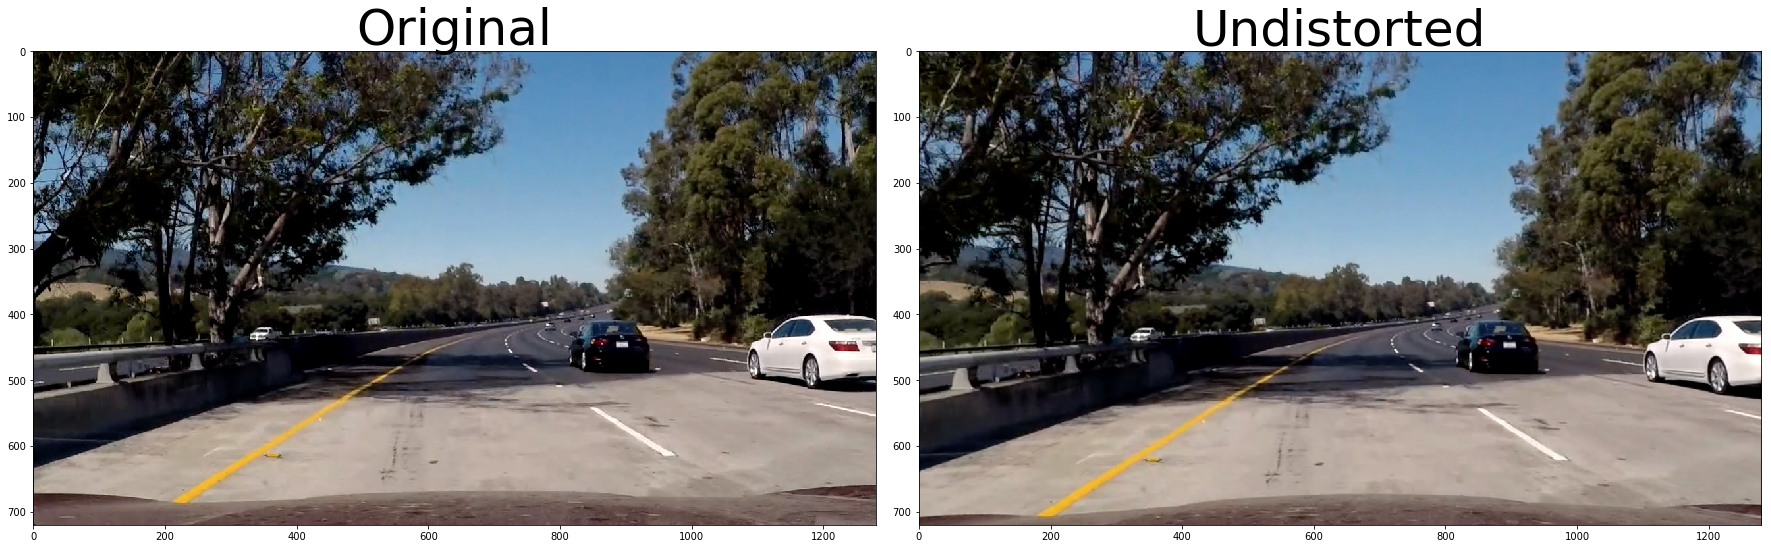

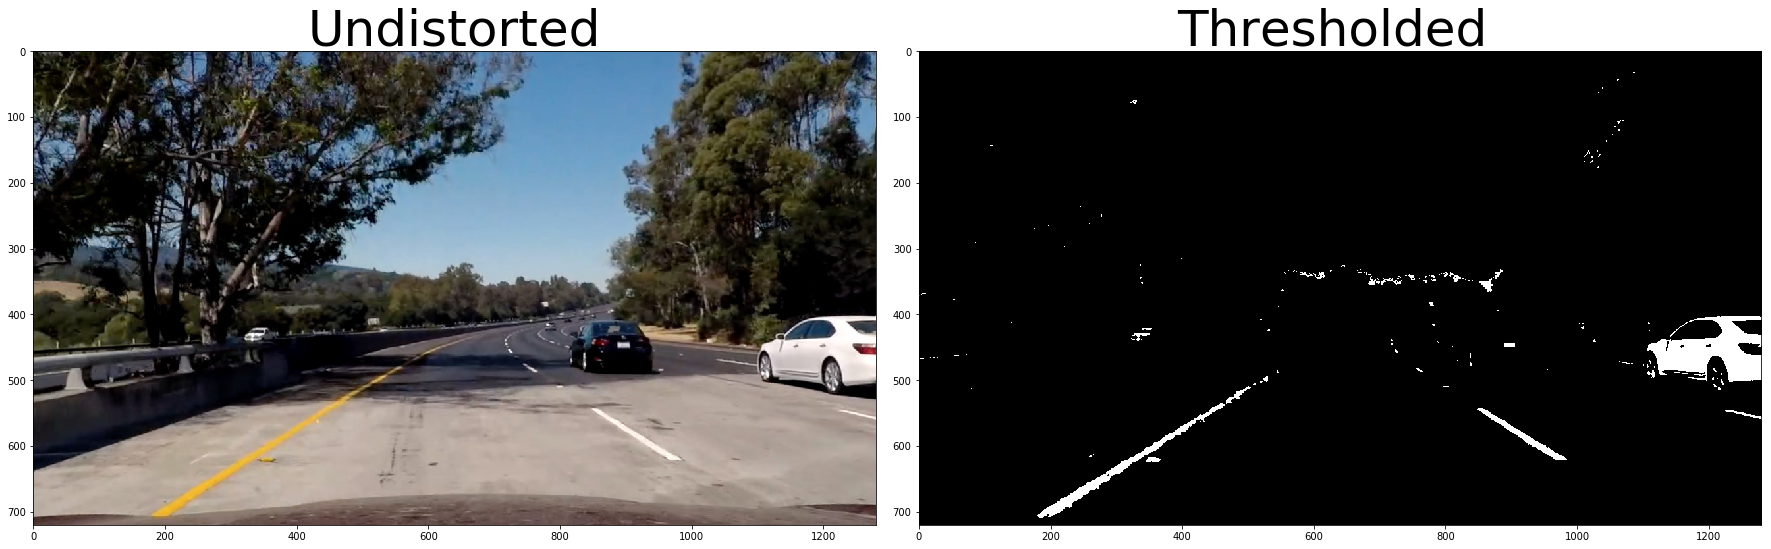

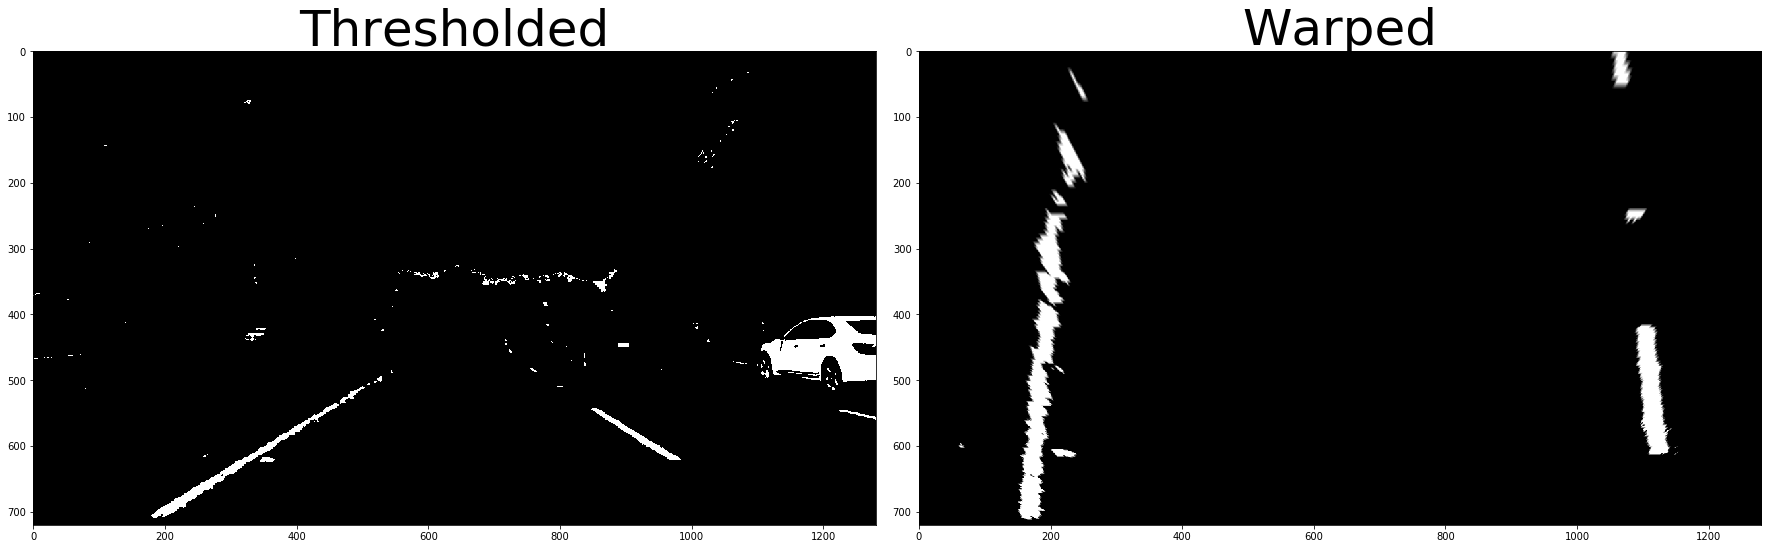

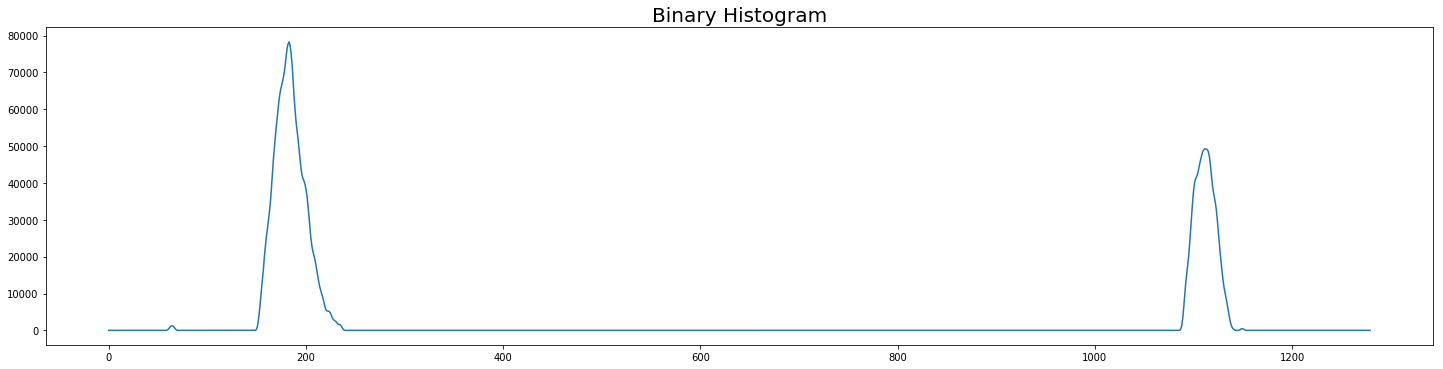

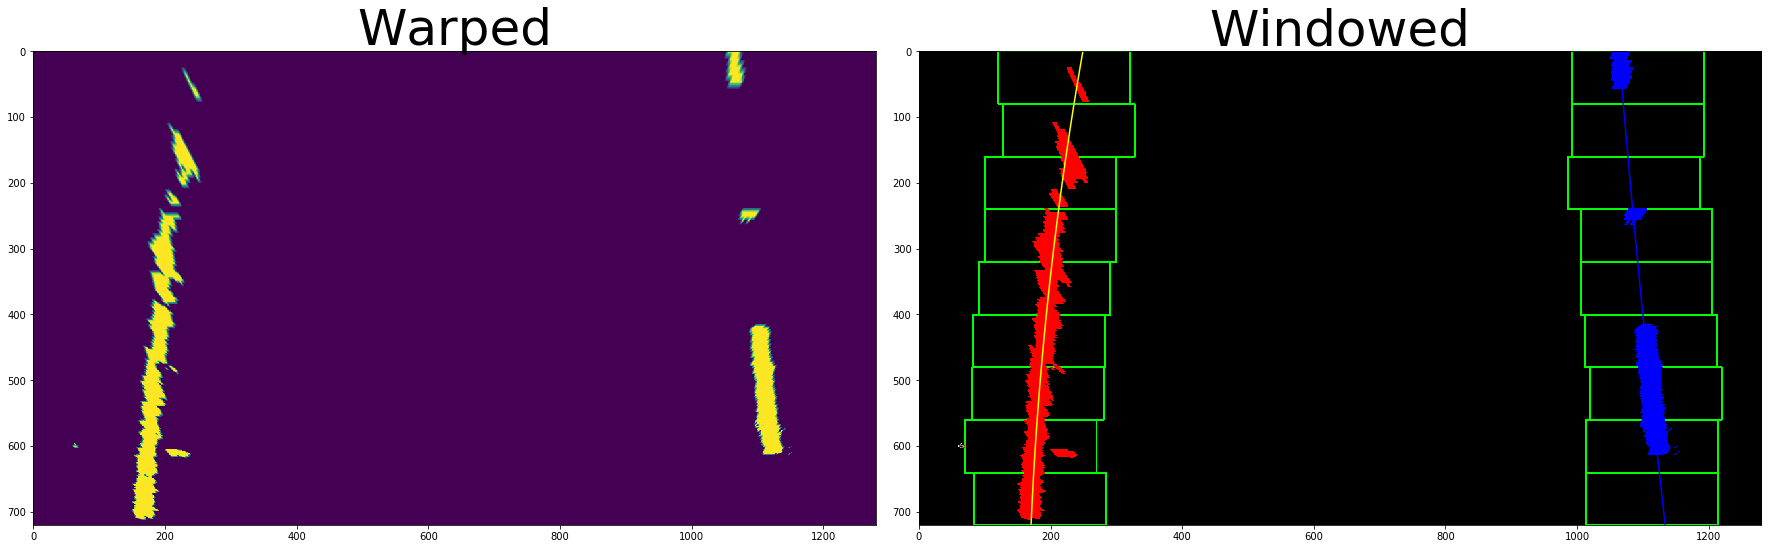

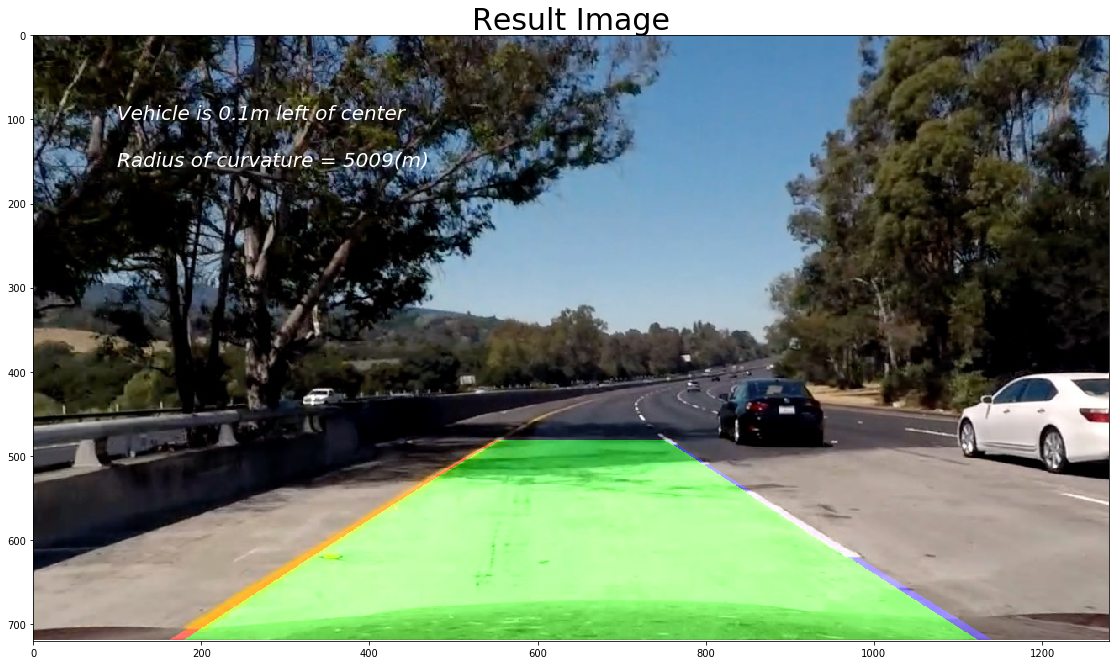

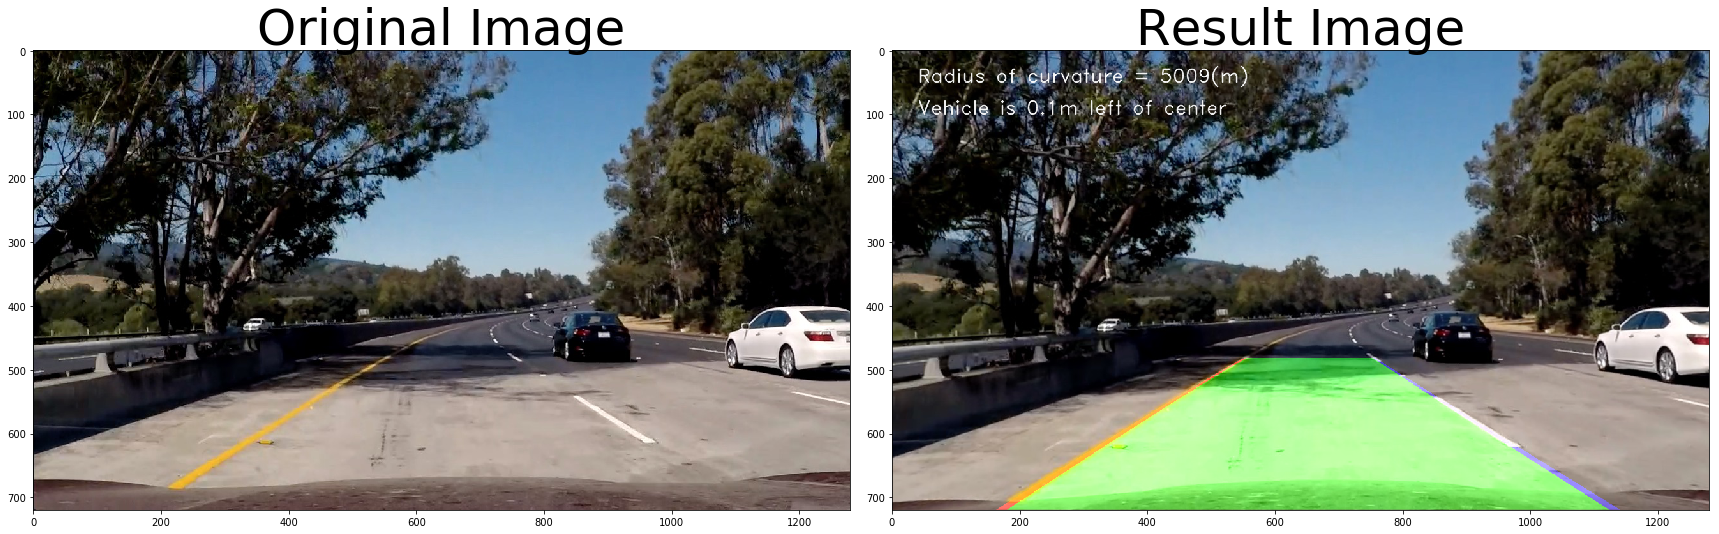

In [109]:
#image = 'test_images/test9.jpg'
image = 'test_images/test5.jpg'

img =  mpimg.imread(image)
result = pipeline(img)
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(result)
ax2.set_title('Result Image', fontsize=50)

In [ ]:
images = glob.glob('test_images/test*.jpg')
#print(images)
for im in images:
    
    image = mpimg.imread(im)
    result=pipeline(image)

    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(result)
    ax2.set_title('Result Image', fontsize=50)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
  

## Process video

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [55]:
test_input = 'project_video.mp4'
test_output = 'project_videoOut.mp4'

clip = VideoFileClip(test_input)

In [ ]:
test_clip = clip.fl_image(pipeline)
test_clip.write_videofile(test_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))